In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report,accuracy_score, roc_auc_score, confusion_matrix,recall_score, precision_score,f1_score
from imblearn.over_sampling import SMOTE
import shap

c:\Users\Asus\Desktop\credit-card-fraud-xgboost-rf-lgbm\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the dataset


In [2]:
df = pd.read_csv("./data/credit_card_transactions.csv")
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0


In [3]:
df.shape

(1296675, 24)

In [4]:
# display summary statistics
print(df.describe())

         Unnamed: 0        cc_num           amt           zip           lat  \
count  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06   
mean   6.483370e+05  4.171920e+17  7.035104e+01  4.880067e+04  3.853762e+01   
std    3.743180e+05  1.308806e+18  1.603160e+02  2.689322e+04  5.075808e+00   
min    0.000000e+00  6.041621e+10  1.000000e+00  1.257000e+03  2.002710e+01   
25%    3.241685e+05  1.800429e+14  9.650000e+00  2.623700e+04  3.462050e+01   
50%    6.483370e+05  3.521417e+15  4.752000e+01  4.817400e+04  3.935430e+01   
75%    9.725055e+05  4.642255e+15  8.314000e+01  7.204200e+04  4.194040e+01   
max    1.296674e+06  4.992346e+18  2.894890e+04  9.978300e+04  6.669330e+01   

               long      city_pop     unix_time     merch_lat    merch_long  \
count  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06   
mean  -9.022634e+01  8.882444e+04  1.349244e+09  3.853734e+01 -9.022646e+01   
std    1.375908e+01  3.019564e+05  1.284128e+07  5.

In [5]:
#columns of dataframe
df.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'merch_zipcode'],
      dtype='object')

# remove columns 'Unnamed: 0'

In [6]:
df = df.drop(columns=["Unnamed: 0"])
#reset the index to be consecutive integers
df = df.reset_index(drop=True)
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0


In [7]:
# checking missing values
print(df.isnull().sum())

trans_date_trans_time         0
cc_num                        0
merchant                      0
category                      0
amt                           0
first                         0
last                          0
gender                        0
street                        0
city                          0
state                         0
zip                           0
lat                           0
long                          0
city_pop                      0
job                           0
dob                           0
trans_num                     0
unix_time                     0
merch_lat                     0
merch_long                    0
is_fraud                      0
merch_zipcode            195973
dtype: int64


In [8]:
initial_proportions = df["is_fraud"].value_counts(normalize=True)
initial_proportions

is_fraud
0    0.994211
1    0.005789
Name: proportion, dtype: float64

#  limit dataset to 100,000 rows while preserving the original number of fraudulent with downsample non-fraudulent transactions.


In [9]:
#desired total number of rows
n_rows = 100000

#count fraud and non-fraud samples
fraud = df[df["is_fraud"] == 1]
non_fraud = df[df["is_fraud"] == 0]

#number of fraud cases
n_fraud = len(fraud)

#calculate how many non-fraud samples to take
n_non_fraud = n_rows - n_fraud

#randomly sample non-fraudulent data
non_fraud_sampled = non_fraud.sample(n=n_non_fraud, random_state=42)

#combine both
df = (
    pd.concat([fraud, non_fraud_sampled], axis=0)
    .sample(frac=1, random_state=42)
    .reset_index(drop=True)
)

print(df.shape)
print(df["is_fraud"].value_counts())
print(df["is_fraud"].value_counts(normalize=True))

(100000, 23)
is_fraud
0    92494
1     7506
Name: count, dtype: int64
is_fraud
0    0.92494
1    0.07506
Name: proportion, dtype: float64


# Visualize the fradulent and non- fradulent data

is_fraud
0    92494
1     7506
Name: count, dtype: int64


C:\Users\Asus\AppData\Local\Temp\ipykernel_21200\199299506.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette=["#1f77b4", "#ff7f0e"])


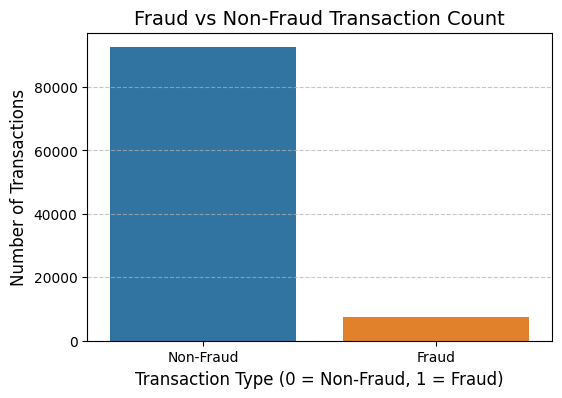

In [10]:
#count of each class
counts = df["is_fraud"].value_counts()
print(counts)
#plot
plt.figure(figsize=(6, 4))
sns.barplot(x=counts.index, y=counts.values, palette=["#1f77b4", "#ff7f0e"])

#customize
plt.title("Fraud vs Non-Fraud Transaction Count", fontsize=14)
plt.xlabel("Transaction Type (0 = Non-Fraud, 1 = Fraud)", fontsize=12)
plt.ylabel("Number of Transactions", fontsize=12)
plt.xticks([0, 1], ["Non-Fraud", "Fraud"])
plt.grid(axis="y", linestyle="--", alpha=0.7)

#display
plt.show()

# Feature Engineering

In [11]:
# convert transaction time to datetime
df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"])

df["trans_hour"] = df["trans_date_trans_time"].dt.hour
df["trans_dayofweek"] = df["trans_date_trans_time"].dt.dayofweek  # starting as monday=0
df["trans_month"] = df["trans_date_trans_time"].dt.month
df["trans_is_weekend"] = df["trans_dayofweek"].isin([5, 6]).astype(int)

# extrAct age from dob
df["dob"] = pd.to_datetime(df["dob"])
current_year = datetime.datetime.now().year
df["age"] = current_year - df["dob"].dt.year

# Droping non-predictive columns

In [12]:


drop_cols = [
    "cc_num",
    "first",
    "last",
    "street",
    "zip",
    "dob",
    "trans_num",
    "unix_time",
    "merch_lat",
    "merch_long",
    "merch_zipcode",
    "trans_date_trans_time",
]
df.drop(columns=drop_cols, inplace=True, errors="ignore")
df.drop(columns=['city','lat','long'], inplace=True, errors="ignore")

In [13]:
df.head()

,merchant,category,amt,gender,state,city_pop,job,is_fraud,trans_hour,trans_dayofweek,trans_month,trans_is_weekend,age
0,fraud_Langworth LLC,personal_care,7.70,M,VA,104396,Production engineer,0,20,5,5,1,75
1,fraud_Reichert-Weissnat,travel,1.68,F,MO,241,Investment analyst,0,19,0,12,0,51
2,fraud_Wuckert-Goldner,home,138.99,F,MI,765,Immunologist,0,20,6,12,1,53
3,fraud_Donnelly PLC,misc_net,7.03,F,WV,5216,Community development worker,0,9,5,6,1,32
4,fraud_Veum-Koelpin,travel,4.70,F,NY,1577385,Herbalist,0,20,1,1,0,44


In [14]:
print(df.columns.tolist())

['merchant', 'category', 'amt', 'gender', 'state', 'city_pop', 'job', 'is_fraud', 'trans_hour', 'trans_dayofweek', 'trans_month', 'trans_is_weekend', 'age']


# Splitting data into training and testing set

In [15]:
# Separate features and target
X = df.drop("is_fraud", axis=1)
y = df["is_fraud"]



In [16]:
#feature 
X

,merchant,category,amt,gender,state,city_pop,job,trans_hour,trans_dayofweek,trans_month,trans_is_weekend,age
0,fraud_Langworth LLC,personal_care,7.70,M,VA,104396,Production engineer,20,5,5,1,75
1,fraud_Reichert-Weissnat,travel,1.68,F,MO,241,Investment analyst,19,0,12,0,51
2,fraud_Wuckert-Goldner,home,138.99,F,MI,765,Immunologist,20,6,12,1,53
3,fraud_Donnelly PLC,misc_net,7.03,F,WV,5216,Community development worker,9,5,6,1,32
4,fraud_Veum-Koelpin,travel,4.70,F,NY,1577385,Herbalist,20,1,1,0,44
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,fraud_Prohaska-Murray,gas_transport,8.96,M,PA,737,Oceanographer,6,6,3,1,38
99996,fraud_Metz-Boehm,shopping_pos,1.86,F,MO,271,Land/geomatics surveyor,18,3,10,0,53
99997,fraud_Cartwright PLC,kids_pets,53.67,M,KY,1565,"Designer, industrial/product",14,0,12,0,57
99998,fraud_McDermott-Weimann,grocery_pos,304.75,M,IL,27020,Trade mark attorney,2,4,2,0,39


In [17]:
#target
y

0        0
1        0
2        0
3        0
4        0
        ..
99995    1
99996    0
99997    0
99998    1
99999    0
Name: is_fraud, Length: 100000, dtype: int64

In [18]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Encoding categorical columns

In [19]:
cat_col = ["merchant", "category", "state" ,"gender", "job"]
for col in cat_col:
    print(f"{col} : {df[col].nunique()}")

merchant : 693
category : 14
state : 51
gender : 2
job : 494


In [20]:

# Encode binary 'gender' with LabelEncoder
le = LabelEncoder()
X_train["gender"] = le.fit_transform(X_train["gender"])
X_test["gender"] = le.transform(X_test["gender"])

# One-Hot encode 'category' and 'state'
ohe = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")

# Fit on training data
ohe.fit(X_train[["category", "state"]])

# Transform both train and test
train_encoded = ohe.transform(X_train[["category", "state"]])
test_encoded = ohe.transform(X_test[["category", "state"]])

# Convert to DataFrames
encoded_cols = ohe.get_feature_names_out(["category", "state"])
train_encoded_df = pd.DataFrame(
    train_encoded, columns=encoded_cols, index=X_train.index
)
test_encoded_df = pd.DataFrame(test_encoded, columns=encoded_cols, index=X_test.index)

# Drop old columns and concatenate new ones
X_train = pd.concat(
    [X_train.drop(["category", "state"], axis=1), train_encoded_df], axis=1
)
X_test = pd.concat(
    [X_test.drop(["category", "state"], axis=1), test_encoded_df], axis=1
)

# Target encode 'merchant' and 'job'
target_enc = TargetEncoder(cols=["merchant", "job"])
X_train[["merchant", "job"]] = target_enc.fit_transform(
    X_train[["merchant", "job"]], y_train
)
X_test[["merchant", "job"]] = target_enc.transform(X_test[["merchant", "job"]])

# Handle any missing values
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

print("Final Train shape:", X_train.shape)
print("Final Test shape:", X_test.shape)


Final Train shape: (80000, 73)
Final Test shape: (20000, 73)


In [21]:
X_train.head()

,merchant,amt,gender,city_pop,job,trans_hour,trans_dayofweek,trans_month,trans_is_weekend,age,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
17176,0.032895,7.09,1,628,0.074627,2,0,6,0,64,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78538,0.062069,1.35,1,92294,0.048649,7,0,8,0,56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22012,0.124138,146.04,1,95,0.054381,2,3,4,0,31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84685,0.038710,58.41,1,20478,0.103516,10,2,6,0,28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57571,0.016531,6.82,0,241,0.030418,21,2,8,0,45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [22]:
X_test.head()

,merchant,amt,gender,city_pop,job,trans_hour,trans_dayofweek,trans_month,trans_is_weekend,age,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
30158,0.013986,51.04,0,269,0.034749,12,6,1,1,60,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52236,0.187919,9.20,0,2906700,0.099992,17,4,10,0,42,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86972,0.033335,30.07,1,3766,0.034632,14,0,1,0,41,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11071,0.033371,4.00,1,471,0.131980,2,0,6,0,58,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
95975,0.020408,113.30,0,22305,0.083333,20,0,8,0,86,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# RANDOM FOREST


In [23]:
rf = RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)

# Evaluate
print("Classification Report:\n", classification_report(y_test, rf_y_pred))
conf_mat = confusion_matrix(y_test, rf_y_pred)
print("Confusion Matrix:\n", conf_mat)

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     18499
           1       0.98      0.84      0.91      1501

    accuracy                           0.99     20000
   macro avg       0.99      0.92      0.95     20000
weighted avg       0.99      0.99      0.99     20000

Confusion Matrix:
 [[18477    22]
 [  240  1261]]


In [24]:
# function to plot confusion matrix

def plot_confusion_matrix(y_true, y_pred, model_name="Model"):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="cividis",
        linewidths=0.5,
        linecolor="black",
        annot_kws={"size": 14, "weight": "bold"},
        xticklabels=["Not Fraud", "Fraud"],
        yticklabels=["Not Fraud", "Fraud"],
    )

    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()


# plotting the top 10 feature importance for each model
def plot_feature_importance(model, feature_names, model_name, top_n=10):
    importance = model.feature_importances_
    fi_df = pd.DataFrame(
        {"Feature": feature_names, "Importance": importance}
    ).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(fi_df["Feature"][:top_n][::-1], fi_df["Importance"][:top_n][::-1])
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title(f"{model_name} Feature Importance (Top {top_n})")
    plt.show()

# plotting shap values
def explain_model_shap(model, model_name, X_test, top_n=10):
    """
    Generates SHAP values and plots for a trained tree-based model.
    Shows top_n features for class 1 (Fraud).
    """
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # For binary classification, take class 1
    if isinstance(shap_values, list):
        shap_values = shap_values[1]

    print(f"\n--- SHAP summary for {model_name} ---")
    # Beeswarm plot: detailed effect of features
    shap.summary_plot(shap_values, X_test, max_display=top_n, show=True)

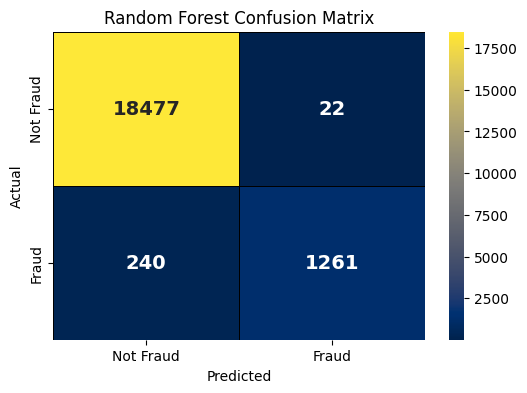

In [25]:
# confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf_y_pred, model_name="Random Forest")

# XGBOOST

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     18499
           1       0.96      0.91      0.94      1501

    accuracy                           0.99     20000
   macro avg       0.98      0.95      0.96     20000
weighted avg       0.99      0.99      0.99     20000

Confusion Matrix:
 [[18442    57]
 [  133  1368]]


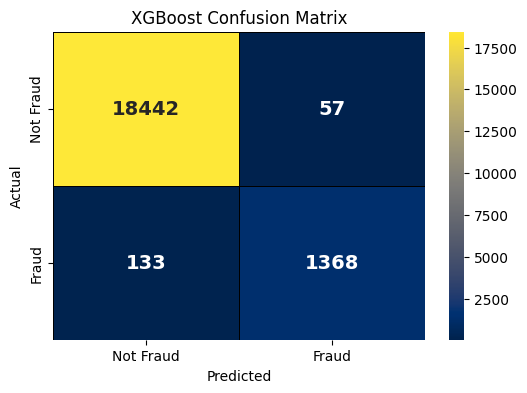

In [26]:
xgboost=XGBClassifier(eval_metric="logloss", random_state=42, n_jobs=-1)
xgboost.fit(X_train, y_train)
xgb_y_pred = xgboost.predict(X_test)

# Evaluate
print("Classification Report:\n", classification_report(y_test, xgb_y_pred))
conf_mat = confusion_matrix(y_test, xgb_y_pred)
print("Confusion Matrix:\n", conf_mat)

# confusion matrix for xgboost
plot_confusion_matrix(y_test, xgb_y_pred, model_name="XGBoost")

# LGBM

[LightGBM] [Info] Number of positive: 6005, number of negative: 73995
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1263
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.075063 -> initscore=-2.511405
[LightGBM] [Info] Start training from score -2.511405
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     18499
           1       0.96      0.91      0.94      1501

    accuracy                           0.99     20000
   macro avg       0.98      0.95      0.96     20000
weighted avg       0.99      0.99      0.99     20000

Confusion Matrix:
 [[18442    57]
 [  133  1368]]


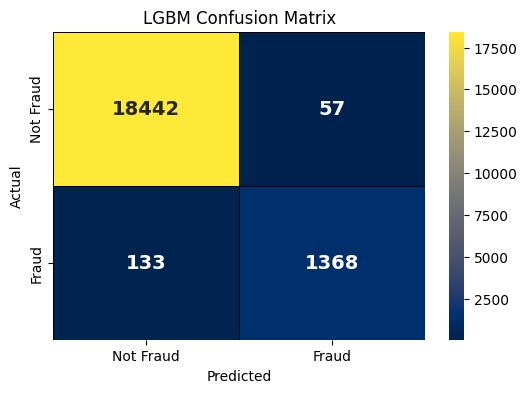

In [27]:
lgbm = LGBMClassifier(random_state=42, n_jobs=-1)
lgbm.fit(X_train, y_train)
lgbm_y_pred = xgboost.predict(X_test)

# Evaluate
print("Classification Report:\n", classification_report(y_test, lgbm_y_pred))
conf_mat = confusion_matrix(y_test, lgbm_y_pred)
print("Confusion Matrix:\n", conf_mat)

# confusion matrix for LGBM
plot_confusion_matrix(y_test, lgbm_y_pred, model_name="LGBM")

# Pipeline for combining smote with modeltraining and tracking using mlflow


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     18499
           1       0.87      0.82      0.85      1501

    accuracy                           0.98     20000
   macro avg       0.93      0.91      0.92     20000
weighted avg       0.98      0.98      0.98     20000



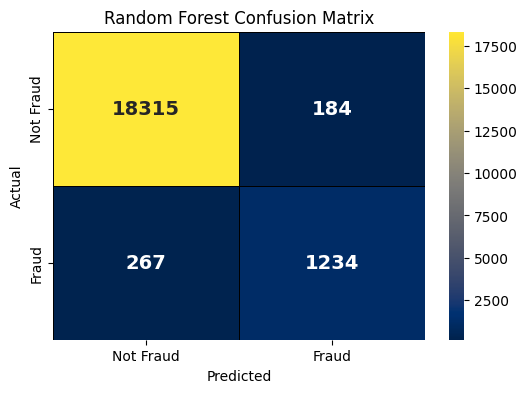

2025/10/09 23:05:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/09 23:05:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


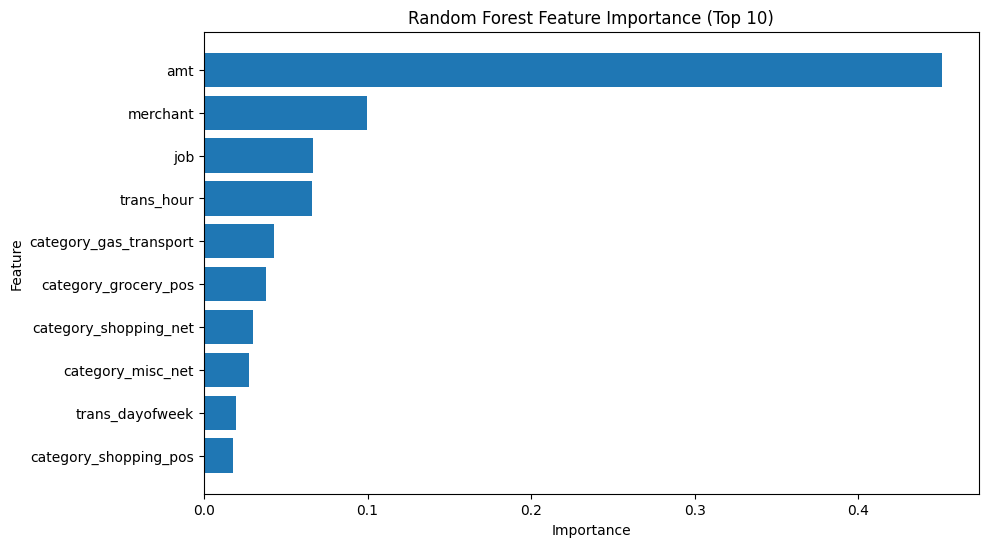

------------------------------


c:\Users\Asus\Desktop\credit-card-fraud-xgboost-rf-lgbm\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:05:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     18499
           1       0.90      0.92      0.91      1501

    accuracy                           0.99     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.99      0.99      0.99     20000



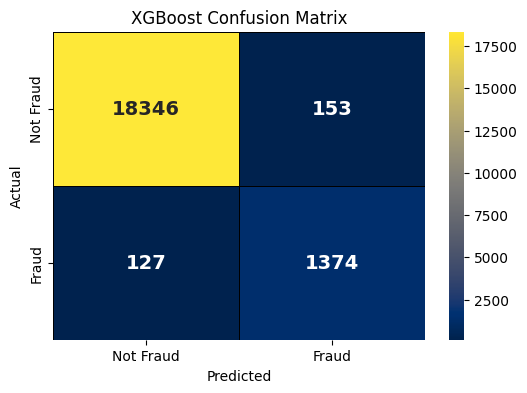

2025/10/09 23:05:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/09 23:05:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


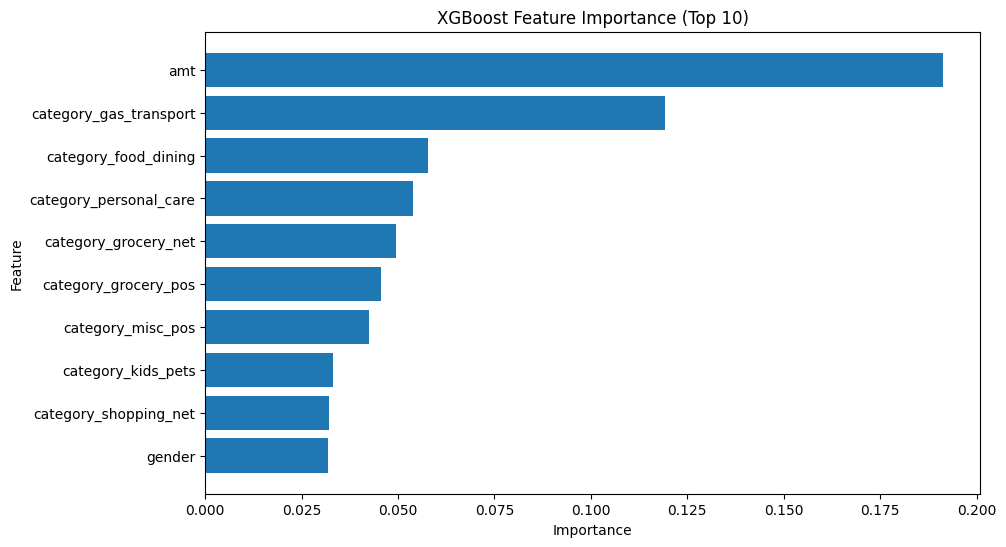

------------------------------
[LightGBM] [Info] Number of positive: 73995, number of negative: 73995
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16052
[LightGBM] [Info] Number of data points in the train set: 147990, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

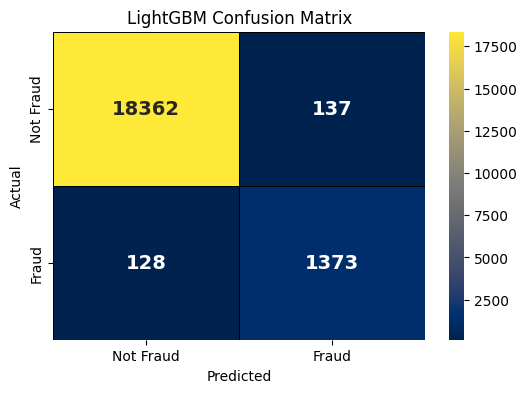

2025/10/09 23:05:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/09 23:05:57 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Asus\AppData\Local\Temp\tmpiexj53sx\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.7.2', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/10/09 23:05:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


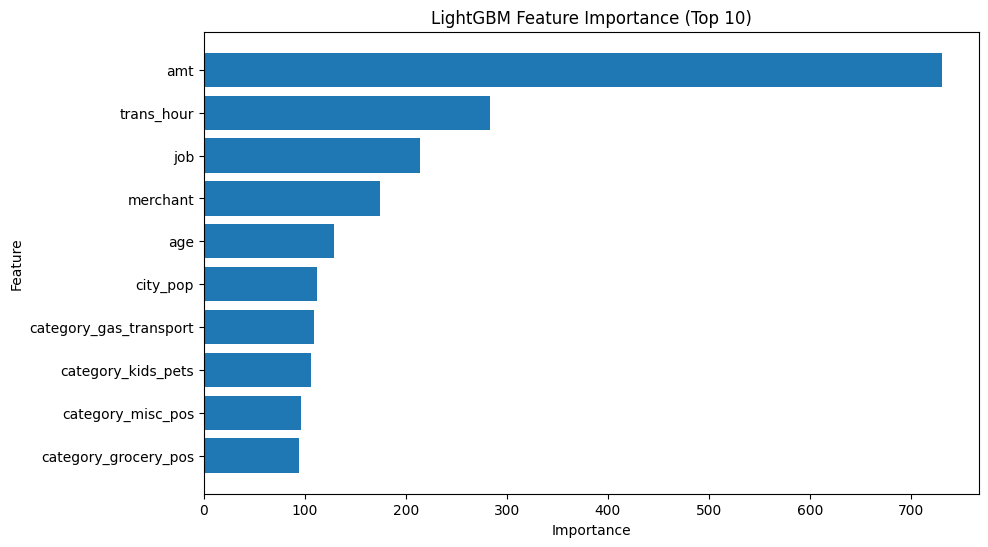

------------------------------


In [28]:
from imblearn.pipeline import Pipeline

# Set up MLflow
mlflow.set_experiment(
    "Credit Card Fraud Detection with RandomForest, XGBoost, LGBM V4.01"
)
# Dictionary of models
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=30, criterion="entropy", max_depth=10, random_state=0
    ),
    "XGBoost": XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=0,
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=100, max_depth=5, learning_rate=0.1, random_state=0
    ),
}


# Dictionary to store trained pipelines
trained_pipelines = {}


# Loop over models
for name, model in models.items():
    with mlflow.start_run(run_name=name):
        pipeline = Pipeline(
            [("smote", SMOTE(sampling_strategy="auto", random_state=0)),
             ("model", model)]
        )

        # fit and predict
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        y_prob = pipeline.predict_proba(X_test)[:, 1]

        # Save trained pipeline for later use (SHAP)
        trained_pipelines[name] = pipeline

        # Log model parameters
        mlflow.log_params(model.get_params())

        # compute and print metrics
        acc = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_prob)

        print(f"\n{name} Classification Report:\n", classification_report(y_test, y_pred))

        # log the merics in mlflow
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("roc_auc", roc_auc)

        # Plot confusion matrix
        plot_confusion_matrix(
            y_test, y_pred, model_name=name,
        )

        # Log model in MLflow
        mlflow.sklearn.log_model(
            pipeline.named_steps["model"], artifact_path=f"{name}_model"
        )

        # Call feature importance plot
        plot_feature_importance(pipeline.named_steps["model"], X_train.columns, model_name=name)

        print("-"*30)

        
        # Call SHAP plot
        # explain_model_shap(
        #     pipeline.named_steps["model"], name, X_test.sample(1000, random_state=42)
        # )

# SHap

In [29]:
trained_pipelines

{'Random Forest': Pipeline(steps=[('smote', SMOTE(random_state=0)),
                 ('model',
                  RandomForestClassifier(criterion='entropy', max_depth=10,
                                         n_estimators=30, random_state=0))]),
 'XGBoost': Pipeline(steps=[('smote', SMOTE(random_state=0)),
                 ('model',
                  XGBClassifier(base_score=None, booster=None, callbacks=None,
                                colsample_bylevel=None, colsample_bynode=None,
                                colsample_bytree=None, device=None,
                                early_stopping_rounds=None,
                                enable_categorical=False, eval_metric='logloss',
                                feature_types=None, feature_weights=None,
                                gamma=None, grow_policy=None,
                                importance_type=None,
                                interaction_constraints=None, learning_rate=0.1,
                        

c:\Users\Asus\Desktop\credit-card-fraud-xgboost-rf-lgbm\venv\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



--- SHAP summary for Random Forest ---


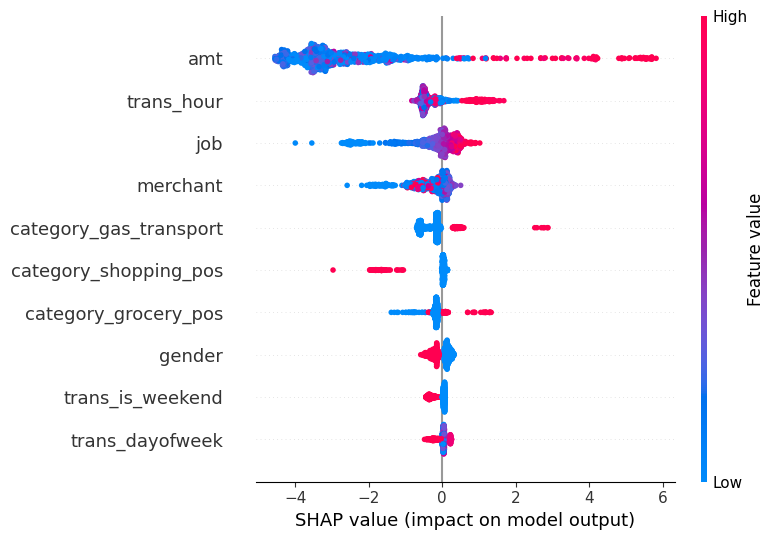

In [30]:
# Select a trained model, e.g., Random Forest
selected_pipeline = trained_pipelines["Random Forest"]
trained_model = selected_pipeline.named_steps["model"]

# Call SHAP plot
explain_model_shap(
    pipeline.named_steps["model"], "Random Forest", X_test.sample(1000, random_state=42)
)